This notebook will walk through the reason that it is necessary to model response times, and the various ways to model them. We will start by generating a design that has trials that vary in reaction time.  This is adapted from Poldrack (2014, Developmental Cognitive Neuroscience).

In [1]:
import numpy as np
import pandas as pd
import nibabel
from nipy.modalities.fmri.hemodynamic_models import spm_hrf
import matplotlib.pyplot as plt
import nipype.algorithms.modelgen as model   # model generation
from nipype.interfaces.base import Bunch
from nipype.interfaces import fsl
from statsmodels.tsa.arima_process import arma_generate_sample
import os
import shutil
from IPython.display import HTML
import seaborn as sns
from nipype.caching import Memory

sns.set_style("white")

mem = Memory(base_dir='.')


def clearmem():
    """function to clear nipype cache"""
    for root, dirs, files in os.walk(mem.base_dir):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))


# generate the design at a higher temporal resolution
tr = 0.1


200423-07:31:30,887 nipype.utils INFO:
	 No new version available.


First generate a design with four events that differ in their duration (by convolving the HRF with increasingly long boxcars).

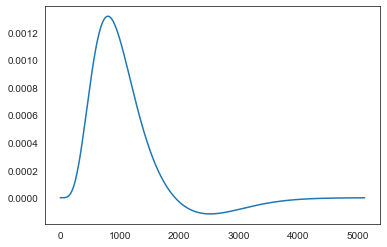

In [2]:
# we will use the spm HRF function
plt.plot(spm_hrf(tr))

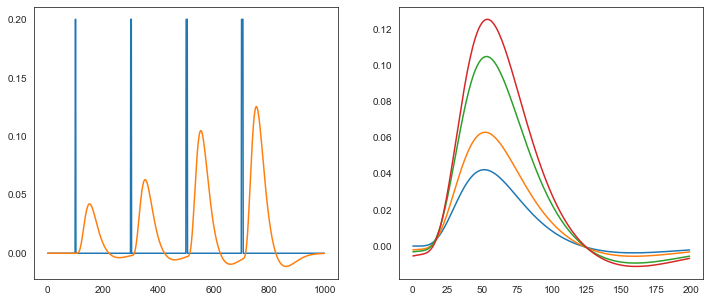

In [3]:
# create a stick function with boxcars of increasing length (2, 3, 5, and 6 timepoints)
variable_sf = np.zeros(1000)

variable_sf[100:102] = 1
variable_sf[300:303] = 1
variable_sf[500:505] = 1
variable_sf[700:706] = 1

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
# plot the HRF against the sticks - reduce scale for plotting against hrf
plt.plot(variable_sf*.2)

# convolve the stick function with the HRF
variable_sf_conv = np.convolve(
    variable_sf, spm_hrf(tr, oversampling=1))[0:len(variable_sf)]
plt.plot(variable_sf_conv)

# plot the evoked responses aligned in time
plt.subplot(1, 2, 2)
hrfs = np.zeros((200, 4))
for i in range(4):
    hrfs[:, i] = variable_sf_conv[(100 + i * 200):(100 + (i + 1) * 200)]
_ = plt.plot(hrfs)

You see that for short events, the length of the impulse is primarily seen in the height of the response, rather than the length of the response.

This effect tapers off for inputs that last longer than the HRF

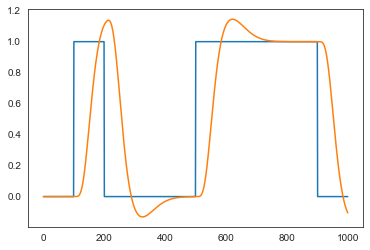

In [4]:
variable_sf_long = np.zeros(1000)

variable_sf_long[100:200] = 1
variable_sf_long[500:900] = 1
plt.plot(variable_sf_long)
variable_sf_long_conv = np.convolve(
    variable_sf_long, spm_hrf(tr, oversampling=1))[0:len(variable_sf)]
_ = plt.plot(variable_sf_long_conv)

Generate a beta-series design matrix that fits a separate regressor for each of the four trials; this is equivalent to separately modeling the intensity of each trial (assuming a constant duration for each).

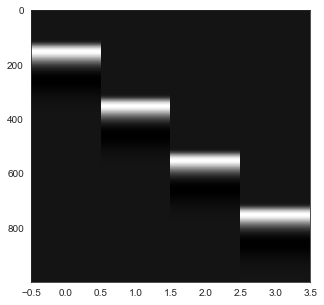

In [5]:
hrf_bases = np.zeros((1000, 4))
hrf_bases[100:104, 0] = 1
hrf_bases[300:304, 1] = 1
hrf_bases[500:504, 2] = 1
hrf_bases[700:704, 3] = 1
desmtx = np.zeros((1000, 4))

for x in range(4):
    desmtx[:, x] = np.convolve(
        hrf_bases[:, x], spm_hrf(tr, oversampling=1))[0:len(variable_sf)]

plt.figure(figsize=(5,5))
plt.imshow(desmtx, aspect='auto', interpolation = 'nearest', cmap='gray')

Now fit the beta-series model, and generate the fitted regressor,  using ordinary least squares.

In [6]:
b_est = np.linalg.inv(desmtx.T.dot(desmtx)).dot(desmtx.T).dot(variable_sf_conv)
print(b_est)
intensity_sf_conv = desmtx.dot(b_est)

[0.49983339 0.75066616 1.25010289 1.49736792]


Now let's plot the fit of the model (which assumed equal duration but varying intensity) to the data (which were generated by varying duration of the underlying impulse).

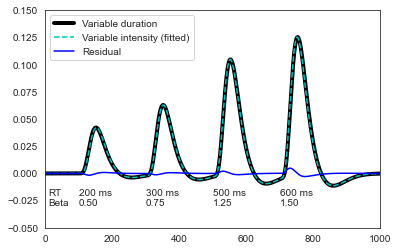

In [7]:
plt.plot(variable_sf_conv, color='k', linewidth=4)
plt.plot(intensity_sf_conv, 'c--')
# plt.plot(constant_sf_conv,color='b')
plt.plot(intensity_sf_conv - variable_sf_conv, color='b')
plt.text(10, -0.02, 'RT')
plt.text(100, -0.02, '200 ms')
plt.text(300, -0.02, '300 ms')
plt.text(500, -0.02, '500 ms')
plt.text(700, -0.02, '600 ms')
plt.text(10, -0.03, 'Beta')
plt.text(100, -0.03, '%0.2f' % b_est[0])
plt.text(300, -0.03, '%0.2f' % b_est[1])
plt.text(500, -0.03, '%0.2f' % b_est[2])
plt.text(700, -0.03, '%0.2f' % b_est[3])

plt.axis([0, 1000, -0.05, 0.15])
_ = plt.legend(['Variable duration',
            'Variable intensity (fitted)',
            'Residual'],
           loc='upper left')

The point to take away from this is that the variable duration and variable intensity have largely indistinguishable effects on the hemodynamic response, at least for relatively short events.

### Modeling reaction times

Now let's look at the various ways that one can model response times for fMRI analysis. First let's generate a design with two conditions that differ in mean response times. We will use a lognormal distribution which is a reasonable approximation to the shape of RT distributions.

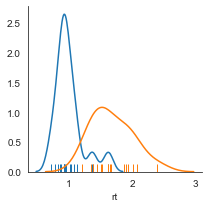

In [8]:
np.random.seed(5)

diff = 0.5  # difference in RT across conditions
ntrials = 32  # trials per condition

rtDf = pd.DataFrame({
    'condition': np.zeros(ntrials),
    'rt': np.zeros(ntrials)
})

rtDf.iloc[int(ntrials / 2):, 0] = 1

rtDf.loc[rtDf.condition == 0, 'rt'] = np.random.lognormal(0.0, 0.2, int(ntrials / 2))
rtDf.loc[rtDf.condition == 1, 'rt'] = np.random.lognormal(diff, 0.2, int(ntrials / 2))

g = sns.FacetGrid(rtDf, hue="condition")
g = g.map(sns.distplot, "rt",  hist=False, rug=True)

rtDf.groupby('condition').rt.mean()

# generate random onsets

trial_length = 16  # length of each trial, including ISI
total_length = trial_length * ntrials
randonsets = np.arange(0, total_length, trial_length)
np.random.shuffle(randonsets)
onsets = np.zeros(len(randonsets))
onsets[rtDf.condition == 0] = np.sort(randonsets[rtDf.condition == 0])
onsets[rtDf.condition == 1] = np.sort(randonsets[rtDf.condition == 1])

Now generate the data using these onsets and durations. We will generate three datasets:
* constant event duration and activation across conditions (cd_ca)
* variable event duration but constant activation across conditions (vd_ca)
* constant event duration but variable activation across condition (cd_va)

In [9]:
times = np.arange(0, total_length, 1 / 100.)
deslen = len(times)  # length of design in high-resolution (10 ms) space
sf_vd_ca = np.zeros(deslen)
sf_cd_ca = np.zeros(deslen)
sf_cd_va = np.zeros(deslen)
activation_effect = 1

for i in range(len(onsets)):
    start = int(onsets[i] * 100.)
    stop_var = int(onsets[i] * 100) + round(rtDf.rt[i] * 10).astype('int')
    stop_const = int(onsets[i] * 100) + round(rtDf.rt.mean() * 10).astype('int')
    sf_vd_ca[start:stop_var] = 1
    sf_cd_ca[start:stop_const] = 1
    sf_cd_va[start:stop_const] = 1 + rtDf.condition[i] * activation_effect  # add activation effect

noiselevel = 0.25
noise = arma_generate_sample([1, 0.4], [1, 0.], total_length) * noiselevel

conv_sf_vd_ca = np.convolve(
    sf_vd_ca, spm_hrf(tr=0.01, oversampling=1.))[:len(sf_vd_ca)]
conv_sf_vd_ca = conv_sf_vd_ca[np.arange(0, len(conv_sf_vd_ca), 100)]
data_vd_ca = conv_sf_vd_ca * 50. + noise

conv_sf_cd_ca = np.convolve(
    sf_cd_ca, spm_hrf(tr=0.01, oversampling=1.))[:len(sf_cd_ca)]
conv_sf_cd_ca = conv_sf_cd_ca[np.arange(0, len(conv_sf_cd_ca), 100)]
data_cd_ca = conv_sf_cd_ca * 50. + noise

conv_sf_cd_va = np.convolve(
    sf_cd_va, spm_hrf(tr=0.01, oversampling=1.))[:len(sf_cd_va)]
conv_sf_cd_va = conv_sf_cd_va[np.arange(0, len(conv_sf_cd_va), 100)]
data_cd_va = conv_sf_cd_va * 50. + noise

Plot an example of a single trial for each of the conditions.

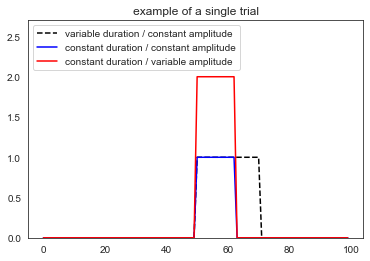

In [10]:
plt.figure()
start = 3150 #1550
end = start + 100
ymax = 2.7

plt.plot(sf_vd_ca[start:end], 'k--')
plt.ylim([0,ymax])
plt.title("example of a single trial")
plt.plot(sf_cd_ca[start:end], 'b-')
plt.ylim([0, ymax])
plt.plot(sf_cd_va[start:end], 'r')
plt.ylim([0, ymax])
plt.legend(["variable duration / constant amplitude",
           "constant duration / constant amplitude",
           "constant duration / variable amplitude"], loc=2)

And plot an example of timeseries for each condition.

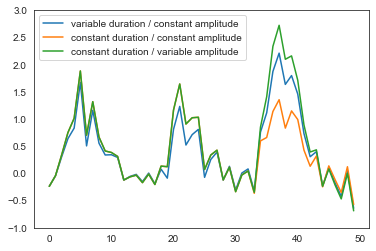

In [11]:
plt.figure()
plt.plot(data_vd_ca[:50], label="variable duration / constant amplitude")
plt.plot(data_cd_ca[:50], label="constant duration / constant amplitude")
plt.plot(data_cd_va[:50], label="constant duration / variable amplitude")
plt.ylim([-1, 3])
plt.legend()

Now we will build several models and estimate the parameters, to see the effect of variable duration on various ways of modeling RT.

First, build a model that assumes constant event durations.  We will build our models using the model specification tools within nipype.

In [14]:
meanrt = rtDf.rt.mean()
info = [Bunch(conditions=['short',
                          'long'],
              onsets=[np.sort(onsets[rtDf.condition == 0]),
                      np.sort(onsets[rtDf.condition == 1])],
              durations=[[meanrt],
                         [meanrt]])]

# create a dummy image for SpecifyModel to look at
if not os.path.exists('tmp.nii.gz'):
    dummy = nibabel.Nifti1Image(
        np.zeros((12, 12, 12, total_length)), np.identity(4))
    dummy.to_filename('tmp.nii.gz')

s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = 'tmp.nii.gz'
s.inputs.time_repetition = 1.0
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()

clearmem()

level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval=1.0,
                                    bases={'dgamma': {'derivs': False}},
                                    session_info=specify_model_results.outputs.session_info,
                                    model_serial_correlations=False)

modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)

200423-07:32:09,199 nipype.workflow INFO:
	 [Node] Setting-up "dcc8746bce1524cb850d36e7f3997ca3" in "/Users/poldrack/Dropbox/code/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-Level1Design/dcc8746bce1524cb850d36e7f3997ca3".
200423-07:32:09,211 nipype.workflow INFO:
	 [Node] Running "dcc8746bce1524cb850d36e7f3997ca3" ("nipype.interfaces.fsl.model.Level1Design")
200423-07:32:09,707 nipype.workflow INFO:
	 [Node] Finished "dcc8746bce1524cb850d36e7f3997ca3".
200423-07:32:09,719 nipype.workflow INFO:
	 [Node] Setting-up "b4789819c3ccf2ea4eee19a0187a330b" in "/Users/poldrack/Dropbox/code/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/b4789819c3ccf2ea4eee19a0187a330b".
200423-07:32:09,746 nipype.workflow INFO:
	 [Node] Running "b4789819c3ccf2ea4eee19a0187a330b" ("nipype.interfaces.fsl.model.FEATModel"), a CommandLine Interface with command:
feat_model run0 
200423-07:32:10,945 nipype.workflow INFO:
	 [Node] Finished "b478981

Model with constant event durations


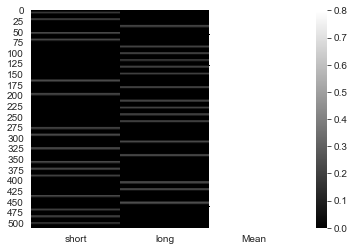

In [15]:
X = np.loadtxt(modelgen_results.outputs.design_file, skiprows=5)
X = np.hstack((X, np.ones((X.shape[0], 1))))

print('Model with constant event durations')
sns.heatmap(X, vmin=0, vmax=0.8, xticklabels=['short', 'long', 'Mean'], cmap='gray')


In [16]:
beta_hat_vd_ca_nort = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_vd_ca)

beta_hat_cd_ca_nort = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_cd_ca)

beta_hat_cd_va_nort = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_cd_va)

betas_nort = np.vstack((beta_hat_vd_ca_nort,
                        beta_hat_cd_ca_nort,
                        beta_hat_cd_va_nort))

df_nort = pd.DataFrame(
    betas_nort,
    columns=['short', 'long', 'Mean'],
    index=['variable duration/constant amplitude',
           'constant duration/constant amplitude',
           'constant duration/variable amplitude'])
HTML(df_nort.to_html())

,short,long,Mean
variable duration/constant amplitude,3.784549,6.578068,0.419321
constant duration/constant amplitude,4.957438,5.074191,0.406054
constant duration/variable amplitude,4.941372,10.162511,0.609168


Note that the first two datasets have equal activation intensity, and thus their betas should be the same, but the increased duration leads to longer activation in the VD/CA condition when the model doesn't include RT. Also notice that the model correctly estimates the effect for the variable amplitude condition.

Now build a model using the actual reaction times as durations to build the regressors (ala Grinband).

In [18]:
info = [Bunch(conditions=['short', 'long'],
              onsets=[onsets[rtDf.condition == 0],
                      onsets[rtDf.condition == 1]],
              durations=[rtDf.loc[rtDf.condition == 0, 'rt'],
                         rtDf.loc[rtDf.condition == 1, 'rt']])]

# create a dummy image for SpecifyModel to look at
if not os.path.exists('tmp.nii.gz'):
    dummy = nibabel.Nifti1Image(
        np.zeros((12, 12, 12, total_length)), np.identity(4))
    dummy.to_filename('tmp.nii.gz')

s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = 'tmp.nii.gz'
s.inputs.time_repetition = 1.0
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()

clearmem()
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval=1.0,
                                    bases={'dgamma': {'derivs': False}},
                                    session_info=specify_model_results.outputs.session_info,
                                    model_serial_correlations=False)

modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)

200423-07:32:45,453 nipype.workflow INFO:
	 [Node] Setting-up "a6d17512d57b5727afa324db34c14e03" in "/Users/poldrack/Dropbox/code/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-Level1Design/a6d17512d57b5727afa324db34c14e03".
200423-07:32:45,473 nipype.workflow INFO:
	 [Node] Running "a6d17512d57b5727afa324db34c14e03" ("nipype.interfaces.fsl.model.Level1Design")
200423-07:32:45,523 nipype.workflow INFO:
	 [Node] Finished "a6d17512d57b5727afa324db34c14e03".
200423-07:32:45,543 nipype.workflow INFO:
	 [Node] Setting-up "c3baa931ced24008b49383252d79f5ec" in "/Users/poldrack/Dropbox/code/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/c3baa931ced24008b49383252d79f5ec".
200423-07:32:45,572 nipype.workflow INFO:
	 [Node] Running "c3baa931ced24008b49383252d79f5ec" ("nipype.interfaces.fsl.model.FEATModel"), a CommandLine Interface with command:
feat_model run0 
200423-07:32:47,43 nipype.workflow INFO:
	 [Node] Finished "c3baa931

Model with variable durations


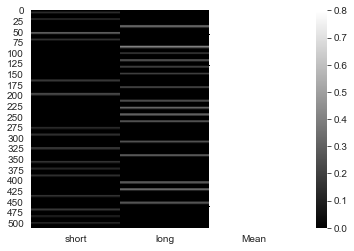

In [19]:
X = np.loadtxt(modelgen_results.outputs.design_file, skiprows=5)
X = np.hstack((X, np.ones((X.shape[0], 1))))

print('Model with variable durations')
sns.heatmap(X, vmin=0, vmax=0.8, xticklabels=['short', 'long', 'Mean'], cmap='gray')

In [20]:
beta_hat_vd_ca_rt = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_vd_ca)
beta_hat_cd_ca_rt = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_cd_ca)
beta_hat_cd_va_rt = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_cd_va)

betas_varrt = np.vstack((beta_hat_vd_ca_rt, beta_hat_cd_ca_rt, beta_hat_cd_va_rt))
df_varrt = pd.DataFrame(
    betas_varrt,
    columns=['short', 'long', 'Mean'],
    index=['variable duration/constant amplitude',
           'constant duration/constant amplitude',
           'constant duration/variable amplitude'])
HTML(df_varrt.to_html())

,short,long,Mean
variable duration/constant amplitude,4.989862,5.171500,0.419321
constant duration/constant amplitude,6.051562,3.763957,0.406054
constant duration/variable amplitude,5.983196,7.567594,0.609168


There are three things to notice here.  First, there is now no difference between conditions in the VD/CA dataset, because these have been removed by the RT modeling.  Second, the RT-unrelated dataset (CD/CA) now has an artifactual difference between conditions, driven by the differences in RT across conditions that are now included in the regressor.  Second, notice that the difference in activation between conditions in the third dataset (where one actually exists) is reduced compared to the previous model, because some of the effect is being removed due to its correlation with the RT difference across conditions.

Now let's build a model that includes a separate parametric regressor for RT alongside the constant duration (unmodulated) regressor.

In [23]:
info = [Bunch(conditions=['short-const',
                          'long-const',
                          'RT'],
              onsets=[onsets[rtDf.condition == 0],
                      onsets[rtDf.condition == 1],
                      onsets],
              durations=[[meanrt],
                         [meanrt],
                         [meanrt]],
              amplitudes=[[1], [1], rtDf.rt - meanrt])]

# create a dummy image for SpecifyModel to look at
dummy = nibabel.Nifti1Image(
    np.zeros((12, 12, 12, total_length)), np.identity(4))
dummy.to_filename('tmp.nii.gz')
s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = 'tmp.nii.gz'
s.inputs.time_repetition = 1.0
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()

clearmem()
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval=1.0,
                                    bases={'dgamma': {'derivs': False}},
                                    session_info=specify_model_results.outputs.session_info,
                                    model_serial_correlations=False)

modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)

200423-07:33:03,325 nipype.workflow INFO:
	 [Node] Setting-up "c342f2ccee6f067815cc2d1fd1f1a97d" in "/Users/poldrack/Dropbox/code/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-Level1Design/c342f2ccee6f067815cc2d1fd1f1a97d".
200423-07:33:03,345 nipype.workflow INFO:
	 [Node] Running "c342f2ccee6f067815cc2d1fd1f1a97d" ("nipype.interfaces.fsl.model.Level1Design")
200423-07:33:03,383 nipype.workflow INFO:
	 [Node] Finished "c342f2ccee6f067815cc2d1fd1f1a97d".
200423-07:33:03,418 nipype.workflow INFO:
	 [Node] Setting-up "d9aa0a2d9fcee6a8261099c5bf062869" in "/Users/poldrack/Dropbox/code/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/d9aa0a2d9fcee6a8261099c5bf062869".
200423-07:33:03,484 nipype.workflow INFO:
	 [Node] Running "d9aa0a2d9fcee6a8261099c5bf062869" ("nipype.interfaces.fsl.model.FEATModel"), a CommandLine Interface with command:
feat_model run0 
200423-07:33:05,540 nipype.workflow INFO:
	 [Node] Finished "d9aa0a2

Model with parametric RT effect


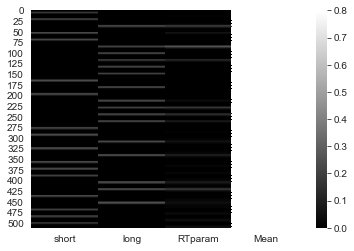

In [24]:
X = np.loadtxt(modelgen_results.outputs.design_file, skiprows=5)
X = np.hstack((X, np.ones((X.shape[0], 1))))

print('Model with parametric RT effect')
sns.heatmap(X, vmin=0, vmax=0.8, xticklabels=['short', 'long', 'RTparam', 'Mean'], cmap='gray')

In [25]:
beta_hat_vd_ca_param = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_vd_ca)
beta_hat_cd_ca_param = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_cd_ca)
beta_hat_cd_va_param = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_cd_va)


betas_param = np.vstack((beta_hat_vd_ca_param, beta_hat_cd_ca_param, beta_hat_cd_va_param))
df_param = pd.DataFrame(
    betas_param,
    columns=['short', 'long', 'RTparam', 'Mean'],
    index=['variable duration/constant amplitude',
           'constant duration/constant amplitude',
           'constant duration/variable amplitude'])

HTML(df_param.to_html())

,short,long,RTparam,Mean
variable duration/constant amplitude,5.024370,5.345286,3.677377,0.419321
constant duration/constant amplitude,4.893994,5.137275,-0.188179,0.406054
constant duration/variable amplitude,4.873159,10.230336,-0.202323,0.609168


Here you see that there are no big diferences between conditions (the first two colums) for the first two datasets, where there was no difference, and the model accurately detected the RT effect for the first dataset.  You also see that the differential activation effect is now roughtly as large as it was for the constant duration model, as it should be.